In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA

In [2]:
def find_source(mic_locations, D_diff):
    mic_D = np.zeros([4,4])
    for i in range(4):
        for j in range((i+1),4):
            mic_D[i,j] = np.sqrt((mic_locations[i,0]-mic_locations[j,0])**2 + (mic_locations[i,1]-mic_locations[j,1])**2)
            mic_D[j,i] = mic_D[i,j]

    P = np.ones([4,4])
    P[:,1:3] = mic_locations
    P[0,3] = D_diff[0,0]
    P[1,3] = D_diff[1,0]
    P[2,3] = D_diff[2,0]
    P[3,3] = D_diff[3,0]
    P = np.transpose(P)

    A = LA.pinv(P)

    B = np.zeros([4,4])
    for i in range(4):
        for j in range(4):
            B[i,j] = 0.5 * ((D_diff[i,0]-D_diff[j,0])**2 - (mic_D[i,j])**2)

    coe1 = np.dot(B, A[:,1:])
    coe2_0 = -np.dot(B, A[:,0])
    coe2_1 = np.dot(B, A[:,0])

    soln_0 = np.dot(LA.pinv(coe1), coe2_0)
    soln_1 = np.dot(LA.pinv(coe1), coe2_1)

    estimations = np.zeros([2,2])
    estimations[0,:] = soln_0[:2]
    estimations[1,:] = soln_1[:2]
    if estimations[0,1] > 0:
        estimate_source = estimations[0,:]
    else:
        estimate_source = estimations[1,:]

    estimate_angle = np.arctan(estimate_source[1]/estimate_source[0])
    
    return estimate_source, estimate_angle

In [3]:
error_range = np.sqrt(np.logspace(-1, 4, num=26, base=np.e))
#print(error_range)

In [4]:
mean_RMSE_list = []
mean_angle_error_list = []
location_solved_list = []
angle_solved_list = []

for std in error_range:
    
    RMSE = []
    angle_error = []
    location_solved = 0
    angle_solved = 0
    
    for ran_idx in range(100):

        random.seed(ran_idx)
        np.random.seed(ran_idx)

        source = [random.uniform(-100,100),random.uniform(0,100)]
        mic1 = [-3.175, 0]
        mic2 = [-0.889, 3.048]
        mic3 = [0.889, 3.048]
        mic4 = [3.175, 0]

        locations = np.zeros([5,2])
        locations[0] = source
        locations[1] = mic1
        locations[2] = mic2
        locations[3] = mic3
        locations[4] = mic4

        mu = np.array([0,0,0,0])
        sigma = np.array([std,std,std,std])
        noise = np.random.normal(mu,sigma)

        D = np.zeros([5,5])
        for i in range(5):
            for j in range((i+1),5):
                if i == 0:
                    D[i,j] = np.sqrt((locations[i,0]-locations[j,0])**2 + (locations[i,1]-locations[j,1])**2 + noise[j-1]) #+ noise[j-1]
                    D[j,i] = D[i,j]
                else:
                    D[i,j] = np.sqrt((locations[i,0]-locations[j,0])**2 + (locations[i,1]-locations[j,1])**2)
                    D[j,i] = D[i,j]
        
        ######################################### Unknown above, Known below ########################################
                
        mic_locations = locations[1:,:]
        
        D_diff = np.zeros([4,4])
        for i in range(4):
            for j in range(4):
                D_diff[i,j] = D[i+1,0] - D[j+1,0]
                    
        ############################################### Main Algorithm ##############################################
        
        estimate_source, estimate_angle = find_source(mic_locations, D_diff)
        
        rmse = np.sqrt((estimate_source[0]-locations[0,0])**2 + (estimate_source[1]-locations[0,1])**2)
        if rmse <= 10:
            location_solved += 1
        RMSE.append(rmse)

        true_angle = np.arctan(locations[0,1]/locations[0,0])
        angle_bias = np.abs(estimate_angle - true_angle) * 180 / np.pi
        if angle_bias < 5:
            angle_solved += 1
        angle_error.append(angle_bias)

    mean_RMSE = np.mean(RMSE)
    mean_angle_error = np.mean(angle_error)
    
    mean_RMSE_list.append(mean_RMSE)
    mean_angle_error_list.append(mean_angle_error)
    location_solved_list.append(location_solved)
    angle_solved_list.append(angle_solved)
    #print(location_solved)
    #print(mean_RMSE)
    #print(angle_solved)
    #print(mean_angle_error)

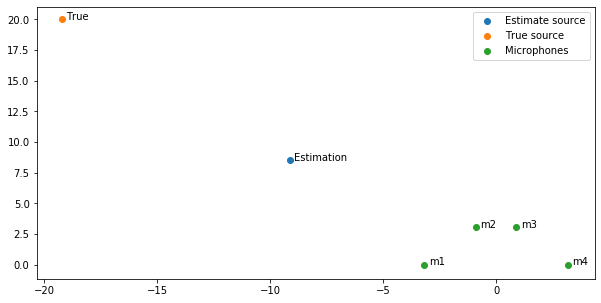

In [5]:
plt.figure(figsize=(10,5))

plt.scatter(estimate_source[0], estimate_source[1], label='Estimate source')
plt.scatter(locations[0,0], locations[0,1], label='True source')
plt.scatter(locations[1:,0], locations[1:,1], label='Microphones')
#plt.xlim([-100,100])
#plt.ylim([0,100])
plt.legend(loc='upper right')

labels = ['True', 'm1', 'm2', 'm3', 'm4']
plt.annotate('Estimation', (estimate_source[0]+0.18, estimate_source[1]-0.07))
plt.annotate(labels[0], (locations[0,0]+0.2, locations[0,1]-0.05))
for i in range(1,5):
    plt.annotate(labels[i], (locations[i,0]+0.2, locations[i,1]))

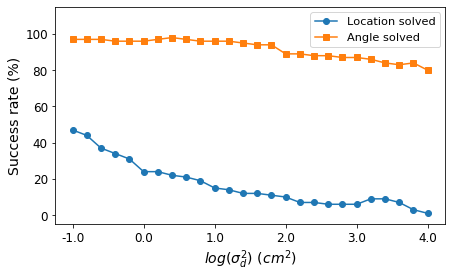

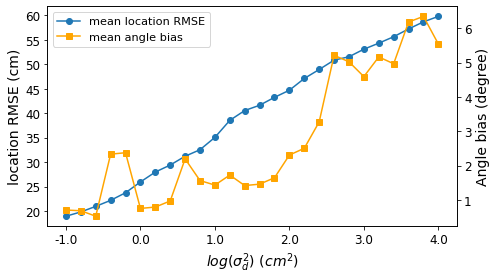

In [6]:
plt.figure(figsize=(7,4))
plt.plot(location_solved_list, marker='o', label='Location solved')
plt.plot(angle_solved_list, marker='s', label='Angle solved')
plt.xticks(np.linspace(0,25,6), np.linspace(-1,4,6))
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')
plt.xlabel('$log(\sigma_d^2)$ $(cm^2)$', fontsize='14')
plt.ylabel('Success rate (%)', fontsize='14')
plt.ylim([-5,115])
plt.legend(loc='upper right', fontsize='11.3')

#########################################################################################

fig, ax1 = plt.subplots(figsize=(7,4))

plt.xlabel('$log(\sigma_d^2)$ $(cm^2)$', fontsize='14')
plt.xticks(fontsize='12')
plt.xticks(np.linspace(0,25,6), np.linspace(-1,4,6))
plt.yticks(fontsize='12')
ax1.set_ylabel('location RMSE (cm)', fontsize='14')
p1 = ax1.plot(mean_RMSE_list, marker='o', label='mean location RMSE')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
plt.yticks(fontsize='12')
ax2.set_ylabel('Angle bias (degree)', fontsize='14')  # we already handled the x-label with ax1
p2 = ax2.plot(mean_angle_error_list, marker='s', label='mean angle bias', color='orange')
ax2.tick_params(axis='y')

lns = p1 + p2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left', fontsize='11.3')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()